# Encoding

## Main Questions

* which encoding for in and output works best in terms of
    * predicitive power
    * smooth input-output response surfaces

## Example
(possible levels: 0,1,2,3,4,5)

### ordinal encoding
3 is encoded as [1,1,1,0,0]

### normal encoding
3 is encoded as 3

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from aimanager.utils.utils import make_dir
from aimanager.utils.merge import merge_files_by_name

sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})


run = 'encoding'

folder = f'../../runs/{run}/train'
plot_folder = f'plots/{run}'

make_dir(plot_folder)

In [2]:
metrics_df = merge_files_by_name(folder, 'metrics.parquet')
confusion_matrix_df = merge_files_by_name(folder, 'confusion_matrix.parquet')
synthethetic_df = merge_files_by_name(folder, 'synthetic_predicitions.parquet')

labels = ['cont_ordinal', 'int_ordinal', 'pun_ordinal', 'y_ordinal']
metrics_df['label'] = ''
bw = ''
for l in labels:
    metrics_df['label'] += (bw + l + ':') + metrics_df[l].astype(str)
    bw = ' '

/Users/levinbrinkmann/repros/algorithmic-institutions/.venv/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


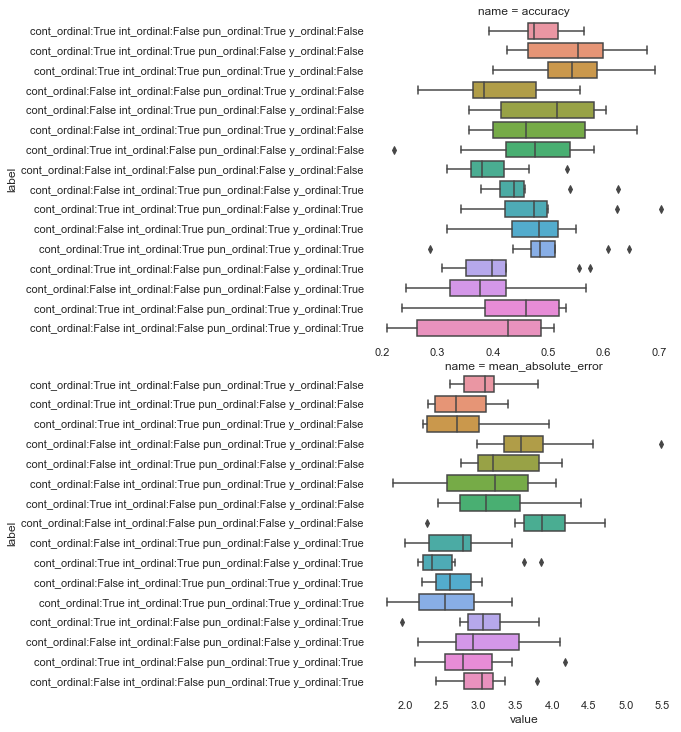

In [3]:
w = (
    (metrics_df['name'].isin(['accuracy', 'mean_absolute_error'])) &
    (metrics_df['set'] == 'test')
)
df = metrics_df[w]
df = df.sort_values('y_ordinal')
sns.catplot(data=df, x='value', row='name', y='label', orient='h', kind='box', sharex=False)

In [4]:
# positive coef -> better

import statsmodels.formula.api as smf
w = (
    (metrics_df['name'] == 'accuracy') &
    (metrics_df['set'] == 'test')
)
df = metrics_df[w]

results = smf.glm("value ~ cont_ordinal+int_ordinal+pun_ordinal+y_ordinal", data=df).fit()
print(results.summary().tables[1])

                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.4124      0.016     25.864      0.000       0.381       0.444
cont_ordinal[T.True]     0.0455      0.014      3.192      0.001       0.018       0.073
int_ordinal[T.True]      0.0757      0.014      5.304      0.000       0.048       0.104
pun_ordinal[T.True]      0.0090      0.014      0.632      0.527      -0.019       0.037
y_ordinal[T.True]       -0.0390      0.014     -2.733      0.006      -0.067      -0.011


/Users/levinbrinkmann/repros/algorithmic-institutions/.venv/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [5]:
# negative coef -> better

import statsmodels.formula.api as smf
w = (
    (metrics_df['name'] == 'mean_absolute_error') &
    (metrics_df['set'] == 'test')
)
df = metrics_df[w]

results = smf.glm("value ~ cont_ordinal+int_ordinal+pun_ordinal+y_ordinal", data=df).fit()
print(results.summary().tables[1])

                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                3.6578      0.097     37.888      0.000       3.469       3.847
cont_ordinal[T.True]    -0.3182      0.086     -3.685      0.000      -0.487      -0.149
int_ordinal[T.True]     -0.4303      0.086     -4.984      0.000      -0.600      -0.261
pun_ordinal[T.True]     -0.0920      0.086     -1.065      0.287      -0.261       0.077
y_ordinal[T.True]       -0.4030      0.086     -4.667      0.000      -0.572      -0.234


### Results

* Ordinal encoding of the contributions as well as the contributions / punishment interactions lead to higher accuracy and lower (better) mean absolute error (mae).
* Ordinal encoding of the target (contribution), leads to lower (worse) accuracy, but higher (better) mae.

## Confusion Matrix

<AxesSubplot:title={'center':'Ordinal target encoding'}, xlabel='y_pred', ylabel='y_true'>

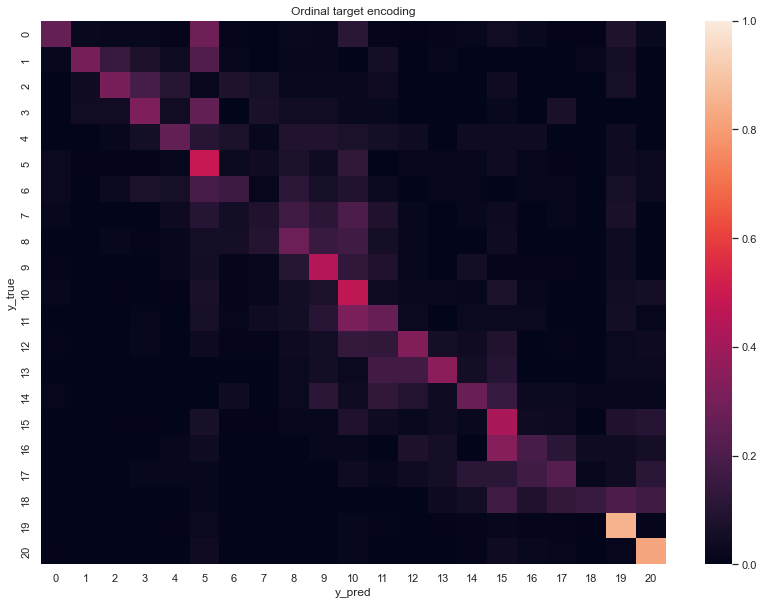

In [6]:
# Todo: double check the normalisation
w = (
    (confusion_matrix_df['cont_ordinal']) &
    (confusion_matrix_df['pun_ordinal']) &
    (confusion_matrix_df['int_ordinal']) &
    (confusion_matrix_df['y_ordinal'])
)

cm_g_df = confusion_matrix_df[w].groupby(['set', 'y_true', 'y_pred'])['value'].sum().reset_index()
cm_g_df['fraction'] = cm_g_df['value'] / cm_g_df.groupby(['set', 'y_true'])['value'].transform('sum')
cm = cm_g_df.pivot_table(index=['set', 'y_true'], columns='y_pred', values='fraction')

plt.figure(figsize=(14,10))
plt.title('Ordinal target encoding')
sns.heatmap(cm.loc['test'], vmin=0, vmax=1)
# plt.savefig(os.path.join(plot_folder, 'confusion_matrix.jpg'), dpi=300, transparent=False)

<AxesSubplot:title={'center':'Non ordinal target encoding'}, xlabel='y_pred', ylabel='y_true'>

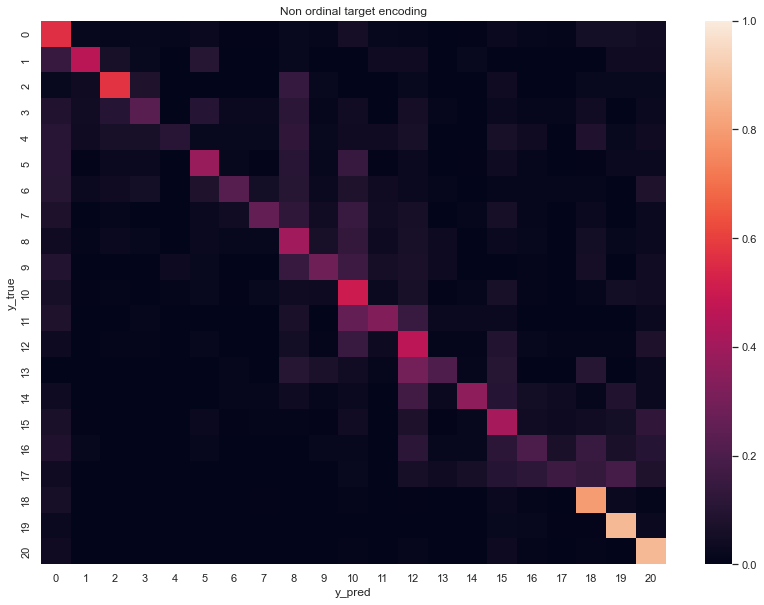

In [7]:
# Todo: double check the normalisation
w = (
    (confusion_matrix_df['cont_ordinal']) &
    (confusion_matrix_df['pun_ordinal']) &
    (confusion_matrix_df['int_ordinal']) &
    (~confusion_matrix_df['y_ordinal'])
)

cm_g_df = confusion_matrix_df[w].groupby(['set', 'y_true', 'y_pred'])['value'].sum().reset_index()
cm_g_df['fraction'] = cm_g_df['value'] / cm_g_df.groupby(['set', 'y_true'])['value'].transform('sum')
cm = cm_g_df.pivot_table(index=['set', 'y_true'], columns='y_pred', values='fraction')

plt.figure(figsize=(14,10))
plt.title('Non ordinal target encoding')
sns.heatmap(cm.loc['test'], vmin=0, vmax=1)

### Interpretation

The confusion matrix looks nicely diagonal. Maybe the previous results can be confirmed here. 
* Ordinal traget: diagonal less prominent, but errors close to diagonal
* Non ordinal target: diagonal more prominent, more errors with 0 and 20 (y_pred)

## Response analysis

(For the lack of a better term)

### Question

How are the predicted contributions respond to changes in contributions?

/var/folders/nv/p5tx0nn545v9h6_w1wtm8cg00000gn/T/ipykernel_4567/4199830073.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['exp_contribution'] = df['proba']


<AxesSubplot:xlabel='prev_punishment', ylabel='prev_contribution'>

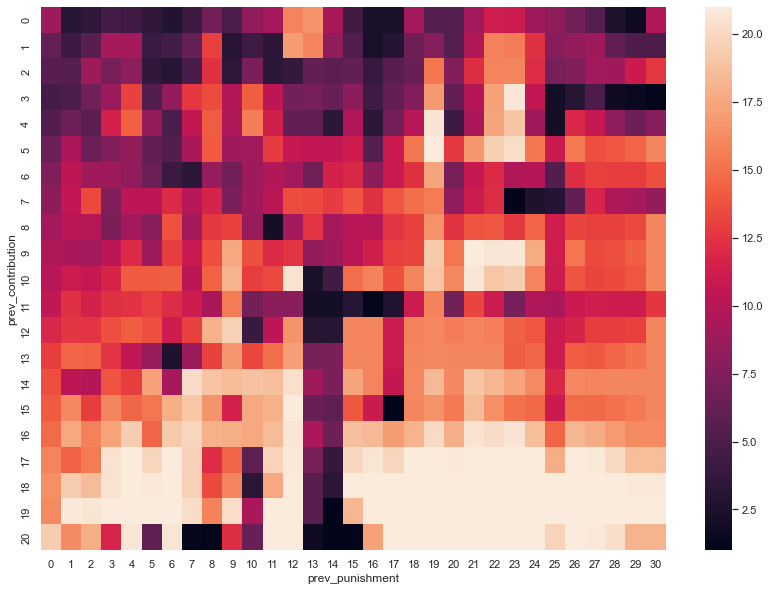

In [10]:
y_ordinal = True
int_ordinal = True

# Todo: double check the normalisation
w = (
    (synthethetic_df['cont_ordinal']) &
    (synthethetic_df['pun_ordinal']) &
    (synthethetic_df['int_ordinal'] == int_ordinal) &
    (synthethetic_df['y_ordinal'] == y_ordinal)
)

df = synthethetic_df[w]

if y_ordinal:
    df['exp_contribution'] = df['proba']
else:
    df['exp_contribution'] = df['contribution'] * df['proba']

dfg = df.groupby(['cont_ordinal', 'int_ordinal', 'pun_ordinal', 'y_ordinal', 'set', 'cv_split', 'prev_contribution', 'round', 'prev_punishment',
       'sample_idx'])['exp_contribution'].sum()
dfg = dfg.reset_index()

cm = dfg.pivot_table(index=['prev_contribution'], columns='prev_punishment', values='exp_contribution')

plt.figure(figsize=(14,10))
sns.heatmap(cm)

## Interpretation

* in particular when using ordinal encoding for the interaction term, an pattern emerges, in which the prev_punishment should be at least as large as (prev_contribution - 20)

A algorithm playing against this model, would select for each prev_contribution the smallest punishment, that still leads to a large expected contribution. I.e. punishment ~  (prev_contribution - 20).

## Conclusions

* Ordinal encoding works well for inputs, for the output it is not yet clear if an ordinal approach is beneficial
* Overall performance is good. That might however also just be a effect of participants being very repetitive in their contributions {in an further analysis we should look at the importance of the different components}
* The response surface is promising, however in the current setup relative noisy.

## Limitations
* the model is overspecified as the interaction includes the direct effects

## Potential Next Steps
* Learning curves
* Contributions of each factor (prev_p, prev_c, interactions)
* MLP model (smoother?!)